### Importación de librerías

In [48]:
# Library load
import os
import pandas as pd
import numpy as np

# Plotting library
import seaborn as sn
import matplotlib.pyplot as plt

# Funciones para hacer cálculo estadístico
import statsmodels.api as sm
from statsmodels.formula.api import ols

# sklearn packages
from sklearn.preprocessing import StandardScaler # Análisis de PCA
from sklearn import metrics # Calcula métricas para un modelo
from sklearn import tree # Cálculo de decision trees
from sklearn.tree import DecisionTreeClassifier # Generación de modelos de decision tree
from sklearn.ensemble import BaggingClassifier # Generación de modelos de bagging
from sklearn.ensemble import RandomForestClassifier # Generación de modelo de random forest
from sklearn.tree import DecisionTreeRegressor # Generación de modelos de decision tree
from sklearn.ensemble import BaggingRegressor # Generación de modelos de bagging
from sklearn.ensemble import RandomForestRegressor # Generación de modelo de random forest
from sklearn.model_selection import train_test_split # Hace split entre training y testing
from sklearn.model_selection import cross_validate # trains model with cross validation
from sklearn.model_selection import GridSearchCV # Optimización de hiperparámetros para un modelo


# Models
# import lightgbm as lgb
import catboost as cat
# import xgboost as xgb

# Confusion matrix viz
from mlxtend.evaluate import confusion_matrix # Calcula la matriz de confusion 
from mlxtend.plotting import plot_confusion_matrix #plot de la matriz de confusión
from mlxtend.classifier import StackingClassifier #stacking classifier
import pingouin as pg

# Shap library
import shap
# print the JS visualization code to the notebook 
shap.initjs()

# Ignoring warning messages
import warnings
warnings.filterwarnings('ignore') #ignora los errores en el notebook

pd.set_option("display.max_columns",100)

---
---
# Análisis exploratorio y limpieza de instancias

In [2]:
raw_data = pd.read_csv('Boosting/input/processed_renting_Barcelona.csv', delimiter = ',')
raw_data.head()

id  price currency   latitude  longitude  sq_meters  sq_meters_built  \
0  536625    850    €/mes  41.401708   2.154077       52.0               55   
1  545910    725    €/mes  41.407221   2.135569       32.0               37   
2  570697    950    €/mes  41.411508   2.164608        NaN               72   
3  591588    750    €/mes  41.402256   2.140764        NaN               45   
4  610243    990    €/mes  41.405327   2.146929        NaN               45   

   rooms  bathrooms  balcony  terrace  exterior orientation  floor  rooftop  \
0      2          1      NaN      NaN       1.0       norte    2.0      NaN   
1      2          1      1.0      NaN       1.0         sur    3.0      NaN   
2      3          1      NaN      NaN       1.0         NaN    4.0      NaN   
3      1          1      1.0      NaN       1.0       norte    4.0      NaN   
4      1          1      NaN      NaN       1.0         sur    3.0      NaN   

   elevator  doorman  pool   ac heating  year_built  quality       city  \
0       0.0      NaN   NaN  1.0     NaN         NaN        2  Barcelona   
1       1.0      NaN   NaN  1.0     NaN      1962.0        2  Barcelona   
2       1.0      NaN   NaN  1.0     NaN         NaN        2  Barcelona   
3       1.0      NaN   NaN  NaN     NaN      1936.0        2  Barcelona   
4       1.0      NaN   NaN  NaN     gas         NaN        2  Barcelona   

                 neighborhood  dist_city_center  furniture  garage  \
0                      Gràcia          2.026455        3.0     NaN   
1  Sant Gervasi - La Bonanova          3.582409        NaN     NaN   
2            El Baix Guinardó          2.663025        3.0     NaN   
3  Sant Gervasi - La Bonanova          2.910067        3.0     NaN   
4         Sarrià-Sant Gervasi          2.727149        3.0     NaN   

  property_type  garden closest_station  dist_closest_station  \
0          piso     NaN         Fontana              0.094111   
1          piso     NaN       Vallcarca              0.902561   
2          piso     NaN        Alfons X              0.188177   
3          piso     NaN         Lesseps              0.892917   
4          piso     NaN         Lesseps              0.293784   

        created_at        last_seen  
0   9/1/2021 15:58   10/4/2021 6:01  
1   9/2/2021 15:24   9/8/2021 12:29  
2  8/28/2021 23:52  8/28/2021 23:52  
3  8/29/2021 11:25   9/8/2021 12:29  
4  8/30/2021 13:48  8/30/2021 14:04

Primero revisamos la existencia de NAs en la data para evaluar qué podremos hacer con los datos importados.

In [3]:
raw_data.isnull().sum() / len(raw_data) * 100 # Calcula la proporción de null values sobre todas las variables

id                        0.000000
price                     0.000000
currency                  0.000000
latitude                  0.000000
longitude                 0.000000
sq_meters                41.578452
sq_meters_built           0.000000
rooms                     0.000000
bathrooms                 0.000000
balcony                  59.009645
terrace                  77.322983
exterior                  7.833451
orientation              56.645495
floor                    23.123971
rooftop                  92.742884
elevator                  3.022818
doorman                 100.000000
pool                     96.224418
ac                       51.940720
heating                  35.638673
year_built               52.881675
quality                   0.000000
city                      0.000000
neighborhood              0.000000
dist_city_center          0.000000
furniture                14.725947
garage                   95.471654
property_type             0.023524
garden              

Vemos que para el análisis buscado, hay alunas variables que no trataremos por su complejidad, como es el caso de longitude y latitude, id, currency, quality, created_at y last_seen.

Pero por otro lado, hay algunas otras que he preferido eliminar por su alto grado de NAs y su posible interpretación errónea.

In [4]:
data_trans = raw_data.drop(["id", 
                        "doorman", 
                        "latitude", 
                        "longitude",
                        "currency", 
                        "quality", 
                        "sq_meters",
                        "created_at",
                        "last_seen"], axis=1) # inplace=True

Por otro lado, considerando que las siguientes variables son binarias (al final es un si o no), es bastante probable que los NAs se refieran a un "no" antes que a una variable desconocida. Por ejemplo, sabemos que en barcelona es bastante más dificil que las viviendas tenga garaje o jardín, por lo que concuerda con su alto porcentaje de NAs. Por este motivo, los reemplazamos por 0.

In [5]:
data_to_null = ['balcony', 'terrace', 'exterior', 'rooftop', 'elevator', 'pool', 'ac','heating', 'garden', 'garage']
for i in range(0,len(data_to_null)):
   data_trans[data_to_null[i]].fillna(0, inplace = True)
 
data_trans.head()

price  sq_meters_built  rooms  bathrooms  balcony  terrace  exterior  \
0    850               55      2          1      0.0      0.0       1.0   
1    725               37      2          1      1.0      0.0       1.0   
2    950               72      3          1      0.0      0.0       1.0   
3    750               45      1          1      1.0      0.0       1.0   
4    990               45      1          1      0.0      0.0       1.0   

  orientation  floor  rooftop  elevator  pool   ac heating  year_built  \
0       norte    2.0      0.0       0.0   0.0  1.0       0         NaN   
1         sur    3.0      0.0       1.0   0.0  1.0       0      1962.0   
2         NaN    4.0      0.0       1.0   0.0  1.0       0         NaN   
3       norte    4.0      0.0       1.0   0.0  0.0       0      1936.0   
4         sur    3.0      0.0       1.0   0.0  0.0     gas         NaN   

        city                neighborhood  dist_city_center  furniture  garage  \
0  Barcelona                      Gràcia          2.026455        3.0     0.0   
1  Barcelona  Sant Gervasi - La Bonanova          3.582409        NaN     0.0   
2  Barcelona            El Baix Guinardó          2.663025        3.0     0.0   
3  Barcelona  Sant Gervasi - La Bonanova          2.910067        3.0     0.0   
4  Barcelona         Sarrià-Sant Gervasi          2.727149        3.0     0.0   

  property_type  garden closest_station  dist_closest_station  
0          piso     0.0         Fontana              0.094111  
1          piso     0.0       Vallcarca              0.902561  
2          piso     0.0        Alfons X              0.188177  
3          piso     0.0         Lesseps              0.892917  
4          piso     0.0         Lesseps              0.293784

In [6]:
data_trans["heating"].value_counts()

0             3030
gas           1700
na            1548
individual     785
electric       746
bomba          693
Name: heating, dtype: int64

In [7]:
data_trans["furniture"].value_counts()

3.0    7250
Name: furniture, dtype: int64

También vemos que en la variable heating tenemos unos NA que están como campos de texto y por otro lado, tenemos a furniture que aparentemente solo existe como "3" y NA, y se ha decidido convertir a binario.

In [8]:
data_trans["orientation"].fillna("unknown", inplace = True)
data_trans["property_type"].fillna("unknown", inplace = True)

# data_trans["furniture"].value_counts()
data_trans["furniture"].fillna(0, inplace = True)
data_trans["furniture"].replace({3: 1}, inplace=True)

data_trans["heating"].replace({"na": "none"}, inplace=True)
data_trans["heating"].replace({0: "none"}, inplace=True)

data_trans['property_age'] = 2022 - data_trans['year_built'] # crear year built
data_trans.drop(["year_built"], axis=1, inplace=True)

data_trans.head()

price  sq_meters_built  rooms  bathrooms  balcony  terrace  exterior  \
0    850               55      2          1      0.0      0.0       1.0   
1    725               37      2          1      1.0      0.0       1.0   
2    950               72      3          1      0.0      0.0       1.0   
3    750               45      1          1      1.0      0.0       1.0   
4    990               45      1          1      0.0      0.0       1.0   

  orientation  floor  rooftop  elevator  pool   ac heating       city  \
0       norte    2.0      0.0       0.0   0.0  1.0    none  Barcelona   
1         sur    3.0      0.0       1.0   0.0  1.0    none  Barcelona   
2     unknown    4.0      0.0       1.0   0.0  1.0    none  Barcelona   
3       norte    4.0      0.0       1.0   0.0  0.0    none  Barcelona   
4         sur    3.0      0.0       1.0   0.0  0.0     gas  Barcelona   

                 neighborhood  dist_city_center  furniture  garage  \
0                      Gràcia          2.026455        1.0     0.0   
1  Sant Gervasi - La Bonanova          3.582409        0.0     0.0   
2            El Baix Guinardó          2.663025        1.0     0.0   
3  Sant Gervasi - La Bonanova          2.910067        1.0     0.0   
4         Sarrià-Sant Gervasi          2.727149        1.0     0.0   

  property_type  garden closest_station  dist_closest_station  property_age  
0          piso     0.0         Fontana              0.094111           NaN  
1          piso     0.0       Vallcarca              0.902561          60.0  
2          piso     0.0        Alfons X              0.188177           NaN  
3          piso     0.0         Lesseps              0.892917          86.0  
4          piso     0.0         Lesseps              0.293784           NaN

Nuestro dataset está casi limpio, pero nos falta limpiar NAs en el nuevo campo creado de property_age. Tanto para esta variable como para rooms y floor, hemos decidido realizar clasificaciones en grupos que ayuden a los modelos en su eficiencia.

Observando los siguientes histogramas, podemos visualizar una cierta agrupacón que aplicamos más adelante.

array([[<AxesSubplot:title={'center':'property_age'}>]], dtype=object)

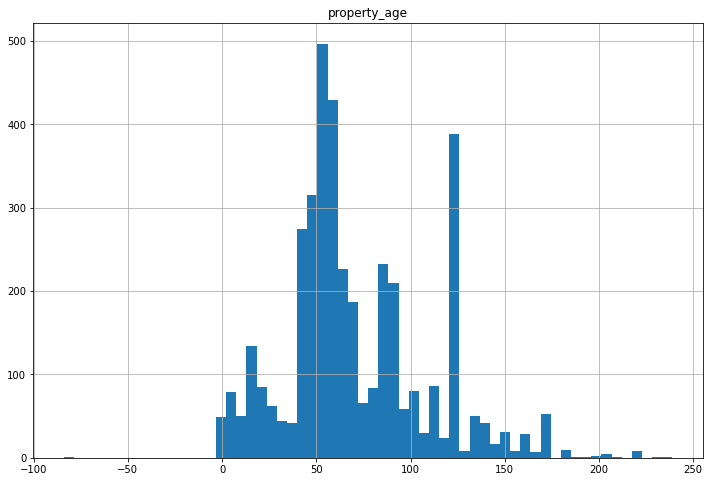

In [9]:
data_trans[['property_age']].hist(bins=60, figsize=(12, 8))

array([[<AxesSubplot:title={'center':'floor'}>]], dtype=object)

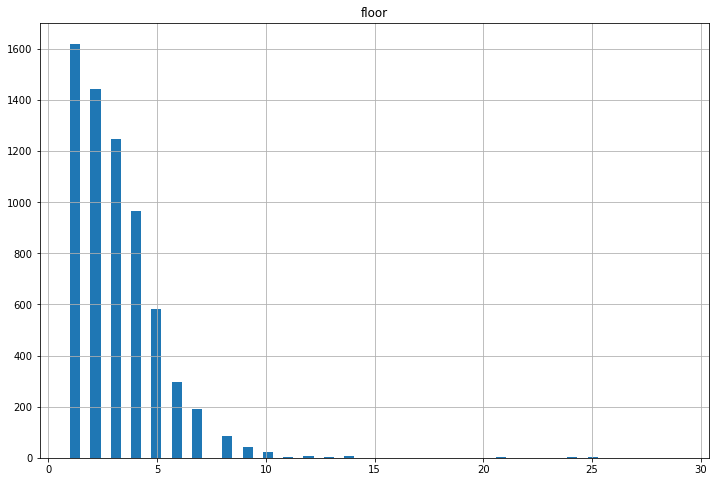

In [10]:
data_trans[['floor']].hist(bins=60, figsize=(12, 8))

array([[<AxesSubplot:title={'center':'rooms'}>]], dtype=object)

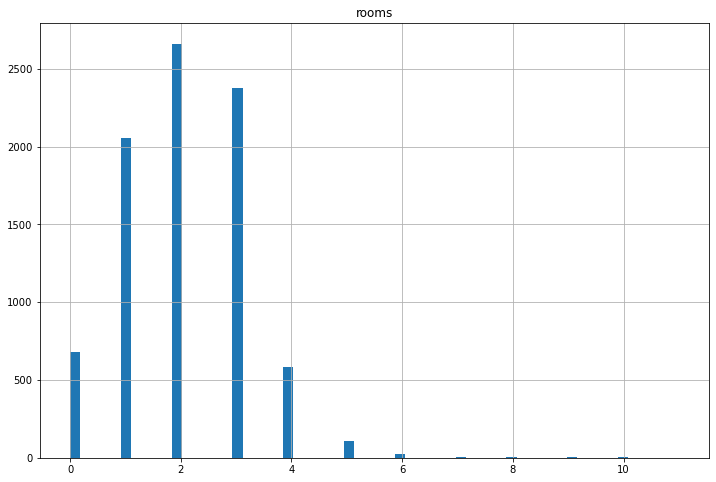

In [11]:
data_trans[['rooms']].hist(bins=60, figsize=(12, 8))

In [12]:
def age_conditions(x):
    if x < 0:
        return "unknown"
    elif ((x >= 0) & (x < 40)):
        return "0 - 40"
    elif ((x >= 40) & (x < 70)):
        return "40 - 70"
    elif ((x >= 70) & (x < 120)):
        return "70 - 120"
    elif ((x >= 120) & (x < 150)):
        return "120 - 150"
    elif ((x >= 150)):
        return "150+"
    else:
        return "unknown"

func1 = np.vectorize(age_conditions)
data_trans['property_age_cat'] = func1(data_trans['property_age'])

def floor_conditions(x):
    if x < 0:
        return "unknown"
    elif ((x == 0) & (x < 2)):
        return "0 - 1"
    elif ((x >= 2) & (x < 6)):
        return "2 - 5"
    elif ((x >= 6)):
        return "6+"
    else:
        return "unknown"

func2 = np.vectorize(floor_conditions)
data_trans['floor_cat'] = func2(data_trans['floor'])

def rooms_conditions(x):
    if x < 0:
        return "unknown"
    elif ((x == 0) & (x < 2)):
        return "0 - 1"
    elif ((x >= 2) & (x < 4)):
        return "2 - 3"
    elif ((x >= 4) & (x < 6)):
        return "4 - 5"
    elif ((x >= 150)):
        return "5+"
    else:
        return "unknown"

func3 = np.vectorize(rooms_conditions)
data_trans['rooms_cat'] = func3(data_trans['rooms'])

data_trans.drop(["property_age"], axis=1, inplace=True)
data_trans.drop(["floor"], axis=1, inplace=True)
data_trans.drop(["rooms"], axis=1, inplace=True)

data_trans.head()


price  sq_meters_built  bathrooms  balcony  terrace  exterior orientation  \
0    850               55          1      0.0      0.0       1.0       norte   
1    725               37          1      1.0      0.0       1.0         sur   
2    950               72          1      0.0      0.0       1.0     unknown   
3    750               45          1      1.0      0.0       1.0       norte   
4    990               45          1      0.0      0.0       1.0         sur   

   rooftop  elevator  pool   ac heating       city  \
0      0.0       0.0   0.0  1.0    none  Barcelona   
1      0.0       1.0   0.0  1.0    none  Barcelona   
2      0.0       1.0   0.0  1.0    none  Barcelona   
3      0.0       1.0   0.0  0.0    none  Barcelona   
4      0.0       1.0   0.0  0.0     gas  Barcelona   

                 neighborhood  dist_city_center  furniture  garage  \
0                      Gràcia          2.026455        1.0     0.0   
1  Sant Gervasi - La Bonanova          3.582409        0.0     0.0   
2            El Baix Guinardó          2.663025        1.0     0.0   
3  Sant Gervasi - La Bonanova          2.910067        1.0     0.0   
4         Sarrià-Sant Gervasi          2.727149        1.0     0.0   

  property_type  garden closest_station  dist_closest_station  \
0          piso     0.0         Fontana              0.094111   
1          piso     0.0       Vallcarca              0.902561   
2          piso     0.0        Alfons X              0.188177   
3          piso     0.0         Lesseps              0.892917   
4          piso     0.0         Lesseps              0.293784   

  property_age_cat floor_cat rooms_cat  
0          unknown     2 - 5     2 - 3  
1          40 - 70     2 - 5     2 - 3  
2          unknown     2 - 5     2 - 3  
3         70 - 120     2 - 5   unknown  
4          unknown     2 - 5   unknown

Comprobamos una vez más que ya no tengamos ningún NA.

In [13]:
data_trans.isnull().sum() / len(data_trans) * 100

price                   0.0
sq_meters_built         0.0
bathrooms               0.0
balcony                 0.0
terrace                 0.0
exterior                0.0
orientation             0.0
rooftop                 0.0
elevator                0.0
pool                    0.0
ac                      0.0
heating                 0.0
city                    0.0
neighborhood            0.0
dist_city_center        0.0
furniture               0.0
garage                  0.0
property_type           0.0
garden                  0.0
closest_station         0.0
dist_closest_station    0.0
property_age_cat        0.0
floor_cat               0.0
rooms_cat               0.0
dtype: float64

Ahora, para efectos del ejercicio, creamos la variable precio_de_alquiler_por_metro_cuadrado, la cual será nuestra variable clave para las futuras predicciones.

In [14]:
data_trans['precio_de_alquiler_por_metro_cuadrado'] = data_trans['price']/data_trans['sq_meters_built']

data_trans.drop(["price"], axis=1, inplace=True)

data = data_trans

array([[<AxesSubplot:title={'center':'precio_de_alquiler_por_metro_cuadrado'}>]],
      dtype=object)

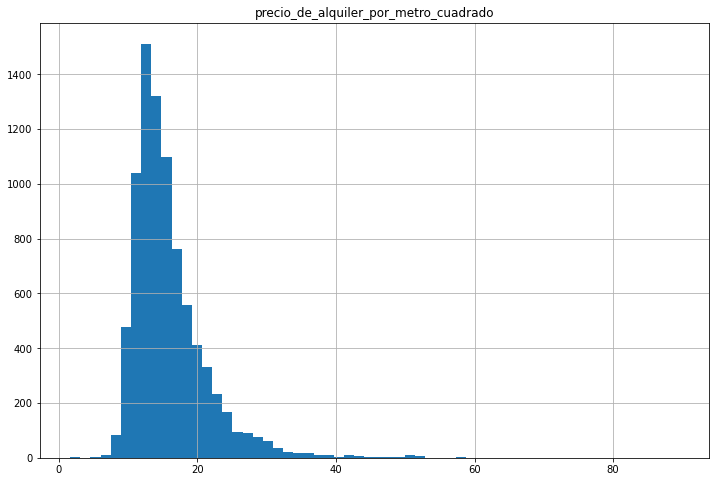

In [15]:
data_trans[['precio_de_alquiler_por_metro_cuadrado']].hist(bins=60, figsize=(12, 8))

Habiendo finalmente organizado la data, procedemos a evaluar las relaciones entre las variables y nuestra nueva variable objetivo utilizando una matriz de correlación así como un test de ANOVA más adelante.

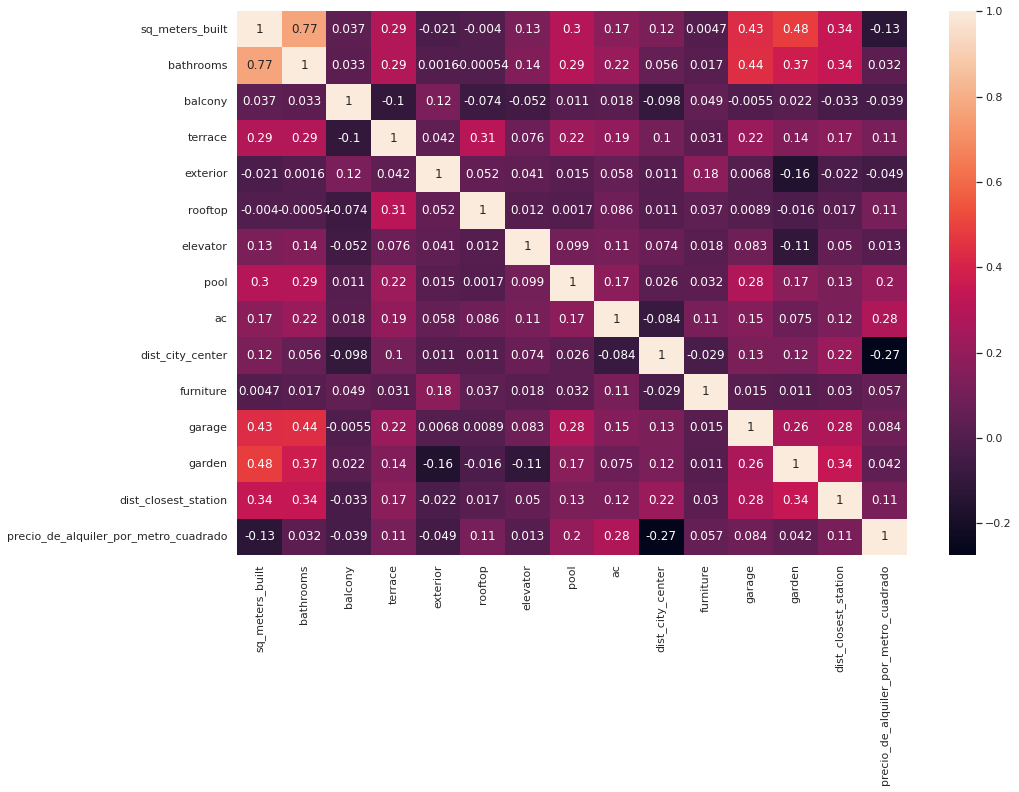

In [16]:
# Análisis de correlación
corrMatrix = data.corr()
# Visualización de la matriz de correlación

sn.set(rc={'figure.figsize':(15,10)})
sn.heatmap(corrMatrix, annot=True)
plt.show()

Aquí se puede ver que aunque no hay correlaciones muy altas, el AC, la distancia al centro de la ciudad, los metros cuadrados,la terraza y el rooftop son las variables numéricas con mayor correlación hacia nuestra variable clave. 

A continuación observamos las recomendaciones según el ANOVA.

In [17]:
Variables_to_anova = ['orientation','property_type','floor_cat','rooms_cat','property_age_cat','balcony','terrace','exterior','rooftop',
                        'elevator','pool','ac','neighborhood','closest_station']

resultado_sig = {'pvalue':[] , 'variable':[] }
resultado_compl = {'pvalue':[] , 'variable':[] }

for vartosee in Variables_to_anova:
    test_anova = pg.anova(data=data, dv='precio_de_alquiler_por_metro_cuadrado', between=vartosee, detailed=False)
    try:
        p = test_anova['p-unc'][0]
    except:
        p = test_anova['np2'][0]

    var = test_anova['Source'][0]
    resultado_compl["pvalue"].append(p)
    resultado_compl["variable"].append(var)
    if p <= 0.05:
        resultado_sig["pvalue"].append(p)
        resultado_sig["variable"].append(var)

pd.DataFrame(resultado_sig).sort_values("pvalue")

pvalue          variable
11  4.935896e-274      neighborhood
12  3.453951e-268   closest_station
3   8.081339e-224         rooms_cat
10  3.352694e-151                ac
1    4.538113e-89     property_type
9    1.700531e-76              pool
4    2.316576e-46  property_age_cat
8    1.009604e-25           rooftop
6    8.238357e-25           terrace
7    6.371193e-06          exterior
5    3.728771e-04           balcony
2    8.860107e-04         floor_cat
0    1.214656e-03       orientation

Según el test de ANOVA, casi todas las variavles obsevadas nos arrojan un p_value inferior a 0.05, por lo que todas estas mencionadas deberían tener un cierto grado de relación con el precio_de_alquiler_por_metro_cuadrado. Principalmente, podemos ver que los más cercanos a cero son el barrio, tener estaciones de metro cercanas y la cantidad de habitaciones.

---
---
# Creación y comparación de modelos

Para el futuro uso en los modelos, procedemos a separar en datasets numéricos y categóricos.

In [18]:
cat_features = ["orientation", "property_type", "property_age_cat", "closest_station", "floor_cat", "rooms_cat","neighborhood","city","heating"]
data_numeric = data.drop(cat_features, axis = 1)
data_numeric

sq_meters_built  bathrooms  balcony  terrace  exterior  rooftop  \
0                  55          1      0.0      0.0       1.0      0.0   
1                  37          1      1.0      0.0       1.0      0.0   
2                  72          1      0.0      0.0       1.0      0.0   
3                  45          1      1.0      0.0       1.0      0.0   
4                  45          1      0.0      0.0       1.0      0.0   
...               ...        ...      ...      ...       ...      ...   
8497               49          1      0.0      1.0       1.0      0.0   
8498              125          1      0.0      0.0       0.0      0.0   
8499               48          1      0.0      0.0       1.0      0.0   
8500               51          1      1.0      0.0       1.0      0.0   
8501               78          1      1.0      0.0       1.0      0.0   

      elevator  pool   ac  dist_city_center  furniture  garage  garden  \
0          0.0   0.0  1.0          2.026455        1.0     0.0     0.0   
1          1.0   0.0  1.0          3.582409        0.0     0.0     0.0   
2          1.0   0.0  1.0          2.663025        1.0     0.0     0.0   
3          1.0   0.0  0.0          2.910067        1.0     0.0     0.0   
4          1.0   0.0  0.0          2.727149        1.0     0.0     0.0   
...        ...   ...  ...               ...        ...     ...     ...   
8497       1.0   0.0  0.0          1.317748        1.0     0.0     0.0   
8498       1.0   0.0  1.0          4.063099        0.0     0.0     0.0   
8499       0.0   0.0  1.0          0.288753        0.0     0.0     0.0   
8500       1.0   0.0  1.0          3.909033        0.0     1.0     0.0   
8501       1.0   0.0  0.0          2.908445        1.0     0.0     0.0   

      dist_closest_station  precio_de_alquiler_por_metro_cuadrado  
0                 0.094111                              15.454545  
1                 0.902561                              19.594595  
2                 0.188177                              13.194444  
3                 0.892917                              16.666667  
4                 0.293784                              22.000000  
...                    ...                                    ...  
8497              0.285426                              18.510204  
8498              0.534462                               7.600000  
8499              0.261938                              19.791667  
8500              0.545561                              18.156863  
8501              0.619454                              12.179487  

[8502 rows x 15 columns]

In [19]:
num_features = ["sq_meters_built", "bathrooms", "balcony", "terrace", "exterior", "rooftop","elevator","pool","ac","dist_city_center","furniture","dist_closest_station","precio_de_alquiler_por_metro_cuadrado"]
data_categoric = data.drop(num_features, axis = 1)
data_categoric

orientation   heating       city                neighborhood  garage  \
0          norte      none  Barcelona                      Gràcia     0.0   
1            sur      none  Barcelona  Sant Gervasi - La Bonanova     0.0   
2        unknown      none  Barcelona            El Baix Guinardó     0.0   
3          norte      none  Barcelona  Sant Gervasi - La Bonanova     0.0   
4            sur       gas  Barcelona         Sarrià-Sant Gervasi     0.0   
...          ...       ...        ...                         ...     ...   
8497       norte      none  Barcelona                 Sant Antoni     0.0   
8498     unknown      none  Barcelona        La Font d'En Fargues     0.0   
8499     unknown  electric  Barcelona                    El Raval     0.0   
8500     unknown      none  Barcelona  La Maternitat i Sant Ramon     1.0   
8501     unknown      none  Barcelona                    La Salut     0.0   

     property_type  garden closest_station property_age_cat floor_cat  \
0             piso     0.0         Fontana          unknown     2 - 5   
1             piso     0.0       Vallcarca          40 - 70     2 - 5   
2             piso     0.0        Alfons X          unknown     2 - 5   
3             piso     0.0         Lesseps         70 - 120     2 - 5   
4             piso     0.0         Lesseps          unknown     2 - 5   
...            ...     ...             ...              ...       ...   
8497       estudio     0.0          Urgell          40 - 70        6+   
8498          piso     0.0        Maragall           0 - 40   unknown   
8499          piso     0.0       Catalunya        120 - 150   unknown   
8500          piso     0.0           Badal          unknown     2 - 5   
8501          piso     0.0         Lesseps          unknown     2 - 5   

     rooms_cat  
0        2 - 3  
1        2 - 3  
2        2 - 3  
3      unknown  
4      unknown  
...        ...  
8497     0 - 1  
8498   unknown  
8499     2 - 3  
8500     2 - 3  
8501     2 - 3  

[8502 rows x 11 columns]

Utilizando get_dummies, realizamos lo que haría el One Hot Encoder para transformar el dataset categórico en numérico y más adelante poder unir ambos para tener un dataset completo y numérico, que pueda ser usado para el Bagging y el RandomForrest.

In [20]:
data_categoric_encoded = pd.get_dummies(data_categoric)
data_categoric_encoded

garage  garden  orientation_ este  orientation_ norte  \
0        0.0     0.0                  0                   1   
1        0.0     0.0                  0                   0   
2        0.0     0.0                  0                   0   
3        0.0     0.0                  0                   1   
4        0.0     0.0                  0                   0   
...      ...     ...                ...                 ...   
8497     0.0     0.0                  0                   1   
8498     0.0     0.0                  0                   0   
8499     0.0     0.0                  0                   0   
8500     1.0     0.0                  0                   0   
8501     0.0     0.0                  0                   0   

      orientation_ oeste  orientation_ sur  orientation_unknown  \
0                      0                 0                    0   
1                      0                 1                    0   
2                      0                 0                    1   
3                      0                 0                    0   
4                      0                 1                    0   
...                  ...               ...                  ...   
8497                   0                 0                    0   
8498                   0                 0                    1   
8499                   0                 0                    1   
8500                   0                 0                    1   
8501                   0                 0                    1   

      heating_bomba  heating_electric  heating_gas  heating_individual  \
0                 0                 0            0                   0   
1                 0                 0            0                   0   
2                 0                 0            0                   0   
3                 0                 0            0                   0   
4                 0                 0            1                   0   
...             ...               ...          ...                 ...   
8497              0                 0            0                   0   
8498              0                 0            0                   0   
8499              0                 1            0                   0   
8500              0                 0            0                   0   
8501              0                 0            0                   0   

      heating_none  city_Barcelona  neighborhood_Baró de Viver  \
0                1               1                           0   
1                1               1                           0   
2                1               1                           0   
3                1               1                           0   
4                0               1                           0   
...            ...             ...                         ...   
8497             1               1                           0   
8498             1               1                           0   
8499             0               1                           0   
8500             1               1                           0   
8501             1               1                           0   

      neighborhood_Can Baró  neighborhood_Can Peguera - El Turó de la Peira  \
0                         0                                               0   
1                         0                                               0   
2                         0                                               0   
3                         0                                               0   
4                         0                                               0   
...                     ...                                             ...   
8497                      0                                               0   
8498                      0                                               0   
8499                      0                        

Ahora unimos todo en un solo dataframe.

In [21]:
OHEd_data = pd.concat([data_numeric, data_categoric_encoded],axis=1)
OHEd_data

sq_meters_built  bathrooms  balcony  terrace  exterior  rooftop  \
0                  55          1      0.0      0.0       1.0      0.0   
1                  37          1      1.0      0.0       1.0      0.0   
2                  72          1      0.0      0.0       1.0      0.0   
3                  45          1      1.0      0.0       1.0      0.0   
4                  45          1      0.0      0.0       1.0      0.0   
...               ...        ...      ...      ...       ...      ...   
8497               49          1      0.0      1.0       1.0      0.0   
8498              125          1      0.0      0.0       0.0      0.0   
8499               48          1      0.0      0.0       1.0      0.0   
8500               51          1      1.0      0.0       1.0      0.0   
8501               78          1      1.0      0.0       1.0      0.0   

      elevator  pool   ac  dist_city_center  furniture  garage  garden  \
0          0.0   0.0  1.0          2.026455        1.0     0.0     0.0   
1          1.0   0.0  1.0          3.582409        0.0     0.0     0.0   
2          1.0   0.0  1.0          2.663025        1.0     0.0     0.0   
3          1.0   0.0  0.0          2.910067        1.0     0.0     0.0   
4          1.0   0.0  0.0          2.727149        1.0     0.0     0.0   
...        ...   ...  ...               ...        ...     ...     ...   
8497       1.0   0.0  0.0          1.317748        1.0     0.0     0.0   
8498       1.0   0.0  1.0          4.063099        0.0     0.0     0.0   
8499       0.0   0.0  1.0          0.288753        0.0     0.0     0.0   
8500       1.0   0.0  1.0          3.909033        0.0     1.0     0.0   
8501       1.0   0.0  0.0          2.908445        1.0     0.0     0.0   

      dist_closest_station  precio_de_alquiler_por_metro_cuadrado  garage  \
0                 0.094111                              15.454545     0.0   
1                 0.902561                              19.594595     0.0   
2                 0.188177                              13.194444     0.0   
3                 0.892917                              16.666667     0.0   
4                 0.293784                              22.000000     0.0   
...                    ...                                    ...     ...   
8497              0.285426                              18.510204     0.0   
8498              0.534462                               7.600000     0.0   
8499              0.261938                              19.791667     0.0   
8500              0.545561                              18.156863     1.0   
8501              0.619454                              12.179487     0.0   

      garden  orientation_ este  orientation_ norte  orientation_ oeste  \
0        0.0                  0                   1                   0   
1        0.0                  0                   0                   0   
2        0.0                  0                   0                   0   
3        0.0                  0                   1                   0   
4        0.0                  0                   0                   0   
...      ...                ...                 ...                 ...   
8497     0.0                  0                   1                   0   
8498     0.0                  0                   0                   0   
8499     0.0                  0                   0                   0   
8500     0.0                  0                   0                   0   
8501     0.0                  0                   0                   0   

      orientation_ sur  orientation_unknown  heating_bomba  heating_electric  \
0                    0                    0              0                 0   
1                    1                    0              0                 0   
2                    0                    1              0                 0   
3                    0                    0              0                 0   
4             

Para prepararnos antes de iniciar con los modelos, separamos en train y test al 80-20.

In [22]:
X = OHEd_data.drop(['precio_de_alquiler_por_metro_cuadrado'], axis = 1)
y = OHEd_data[['precio_de_alquiler_por_metro_cuadrado']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

## Bagging

In [23]:
# we enumerate the values to try
parameters = [{"max_depth":[2,3,4,5,6,7,8,10,15,20,25], "min_samples_split":[1,2,3,4,5,10]}]

#instantiate the classifier
decision_tree_model = DecisionTreeRegressor()

# Grid search function
grid_bag = GridSearchCV(cv = 10, estimator=decision_tree_model, param_grid=parameters, scoring="r2", n_jobs=-1)
grid_bag.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 15, 20, 25],
                          'min_samples_split': [1, 2, 3, 4, 5, 10]}],
             scoring='r2')

In [24]:
grid_bag.best_params_

{'max_depth': 7, 'min_samples_split': 4}

Hemos agregado un n_jobs=-1 en el GridSearchCV para mejorar el rendimiento del notebook utilizando todos los recursos del contenedor de jupyter en docker.

Después de realizar el grid search con cross validation de 10 folds, vemos que los mejores parámetros son una profundidad máxima de 7 generaciones en el arbol y un mínimo de 4 samples por cada split.

Ahora buscaremos los n_estimators más óptimos.

In [25]:
# we enumerate the values to try
parameters = {"n_estimators":[1,5,10,20,50,100,200]}

#instantiate the classifier
decision_tree_model = DecisionTreeRegressor(max_depth = 7, min_samples_split = 4)

#instantiate the classifier
bagging_model = BaggingRegressor(decision_tree_model)

# Grid search function
grid_bag = GridSearchCV(cv = 10, estimator=bagging_model, param_grid=parameters, scoring="r2", n_jobs=-1)
grid_bag.fit(X_train, y_train)
grid_bag.best_params_

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

{'n_estimators': 100}

Ahora que ya tenemos la cantidad de estimadores óptima recomendada (200), procedemos a ejecutar nuestro modelo de bagging.

In [26]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
bag = BaggingRegressor(DecisionTreeRegressor(max_depth = 7, min_samples_split = 4), n_estimators = 200)
# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model = cross_validate(bag, X_train, y_train, cv = 10, scoring = "r2", n_jobs=-1)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for

In [27]:
# for i, score in enumerate(model["test_score"]):
#     print(f"Accuracy for the fold no. {i} on the test set: {score}")

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2321e601c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2321e56ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2321e60a00>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2321e564c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2321e4ab80>],
 'means': []}

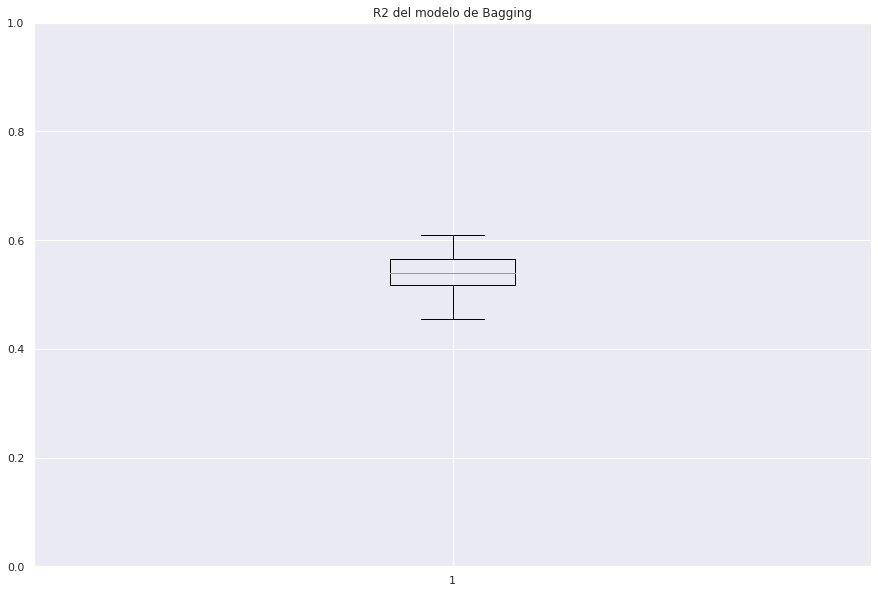

In [28]:
fig1, ax1 = plt.subplots()
ax1.set_title('R2 del modelo de Bagging')
plt.ylim(0, 1)
ax1.boxplot(model["test_score"])

In [29]:
bag = BaggingRegressor(DecisionTreeRegressor(max_depth = 7, min_samples_split = 4), n_estimators = 200)
bag.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=7,
                                                      min_samples_split=4),
                 n_estimators=200)

In [30]:
y_pred = bag.predict(X_train)
# Error en el modelo
metrics.r2_score(y_train, y_pred)

0.6514748134043724

In [31]:
y_pred = bag.predict(X_test)
# Error en la validación #KEY
baggingR2 = metrics.r2_score(y_test, y_pred)
baggingR2

0.5430557355829213

In [66]:
r2s = pd.DataFrame({"Model":"Bagging","Variable":"bag.predict","R2":[baggingR2]})
r2s

Model     Variable        R2
0  Bagging  bag.predict  0.543056



Con los resultados anteriores, vemos que nuestro modelo de bagging ha logrado un R2 de 0.65 para los datos de train y 0.54 para los datos de test, que deja mucho que desear, aunque los R2 en cada fold están bastante consistenes como se puede observar en el boxplot.

Ahora veremos de mejorar esto con los modelos de más adelante.

# Random Forrest

A continuación realizaremos el GridSearch para el Random Forrest para evaluar los mejores parámetros.

In [33]:
# we enumerate the values to try
parameters = [{"n_estimators":[5,10,50,100,150,200], "max_depth": [1,5,10,15]}]

#instantiate the classifier
rf_cv = RandomForestRegressor()

# Grid search function
grid_bag = GridSearchCV(cv = 10, estimator=rf_cv, param_grid=parameters, scoring="r2", n_jobs=-1)
grid_bag.fit(X_train, y_train)
grid_bag.best_params_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

{'max_depth': 15, 'n_estimators': 200}

Para este caso, vemos que los mejores parámetros son 200 estimadores y una profundidad máxima de 15. También utilizamos todos los recursos del contenedor con n_jobs=-1.

In [34]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
rf = RandomForestRegressor(n_estimators = 200, max_depth=15, n_jobs=-1) 
# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model = cross_validate(rf, X_train, y_train, cv = 10, scoring = "r2")
# for i, score in enumerate(model["test_score"]):
#     print(f"Accuracy for the fold no. {i} on the test set: {score}")

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2320d5f9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f227efe9a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2320ccc730>],
 'medians': [<matplotlib.lines.Line2D at 0x7f2321e1b0d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f2321e93130>],
 'means': []}

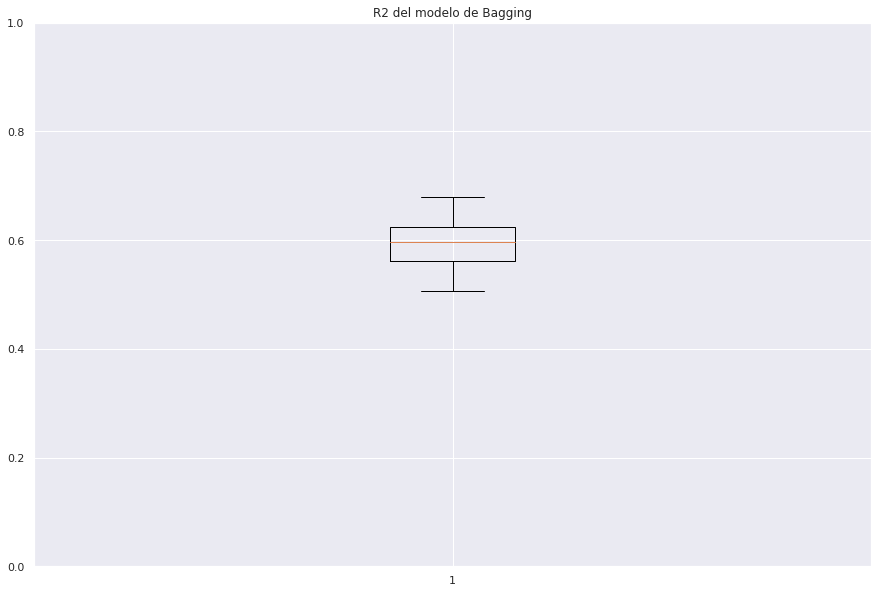

In [35]:
fig1, ax1 = plt.subplots()
ax1.set_title('R2 del modelo de Bagging')
plt.ylim(0, 1)
ax1.boxplot(model["test_score"])

In [36]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
# Error del modelo train
metrics.r2_score(y_train, y_pred)

0.8935148964959475

In [37]:
y_pred = rf.predict(X_test)
# Error de predicción
randomforrestR2 = metrics.r2_score(y_test, y_pred)
randomforrestR2

0.6228380432196589

In [67]:
rfvalvec = pd.DataFrame({"Model":"Random Forrest","Variable":"rf.predict","R2":[randomforrestR2]})
r2s = r2s.append(rfvalvec, ignore_index=True)
r2s


Model     Variable        R2
0         Bagging  bag.predict  0.543056
1  Random Forrest   rf.predict  0.622838

Como podemos observar, los valores de R2 para Random Forrest han mejorado. En el caso del R2 para las variables de train estamos en casi un 0.9, por lo que vemos que dentro de sus mismos datos, es bastante eficiente. Esto también se puede observar por la falta de outliers en los R2 de los 10 folds vistos en el boxplot así como la compresión entre los valores que se mantienen mayormente cerca a la media.

Respecto al R2 en la predicción para test llegamos a un 0.61, que aún es algo bajo, pero mejora en casi 7 puntos al modelo de Bagging.

# CATBOOST

In [39]:
X = data.drop(['precio_de_alquiler_por_metro_cuadrado'], axis = 1)
y = data[['precio_de_alquiler_por_metro_cuadrado']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# create a train/test split with catboost
d_train_cat = cat.Pool(X_train, y_train, cat_features=cat_features)
d_test_cat = cat.Pool(X_test, y_test, cat_features=cat_features)

Para este caso, realizamos una nueva separación de train y test mediante las cat.Pool, utilizando ahora todas las variables de la data extraída y limpiada al comienzo, pero sin el OneHotEncoding, puesto que nos interesa utilizar las variables categóricas. 

Luego pasamos a realizar el grid_search para conocer nuestras variables de learning rate y depth, así como la mejor iteración.

In [40]:
model = cat.CatBoostRegressor(thread_count=-1)

grid = {'learning_rate': [0.05, 0.025, 0.015, 0.01],
        'depth': [8, 10, 12]}

grid_search_result = model.grid_search(grid, 
                                       d_train_cat, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 16.0906536	test: 15.9409629	best: 15.9409629 (0)	total: 71.6ms	remaining: 1m 11s
1:	learn: 15.3696218	test: 15.2074129	best: 15.2074129 (1)	total: 158ms	remaining: 1m 18s
2:	learn: 14.6950040	test: 14.5312430	best: 14.5312430 (2)	total: 181ms	remaining: 1m
3:	learn: 14.0572769	test: 13.8831885	best: 13.8831885 (3)	total: 203ms	remaining: 50.5s
4:	learn: 13.4550932	test: 13.2725941	best: 13.2725941 (4)	total: 226ms	remaining: 45s
5:	learn: 12.8891371	test: 12.6947218	best: 12.6947218 (5)	total: 255ms	remaining: 42.2s
6:	learn: 12.3517471	test: 12.1501355	best: 12.1501355 (6)	total: 277ms	remaining: 39.3s
7:	learn: 11.8462449	test: 11.6381202	best: 11.6381202 (7)	total: 306ms	remaining: 37.9s
8:	learn: 11.3585387	test: 11.1380991	best: 11.1380991 (8)	total: 333ms	remaining: 36.6s
9:	learn: 10.9100233	test: 10.6827862	best: 10.6827862 (9)	total: 366ms	remaining: 36.2s
10:	learn: 10.4803384	test: 10.2411013	best: 10.2411013 (10)	total: 403ms	remaining: 36.2s
11:	learn: 10.0870041

In [41]:
grid_search_result['params']

{'depth': 10, 'learning_rate': 0.05}

Los parámetros recomendados son 10 de profundidad y 0.05 de learning_rate, los aplicamos en el cross validation con 950 iteraciones, un poco más que la recomendada anteriormente.

In [42]:
# Model cross validation
params = {"iterations": 950
          , "depth": 10
          , "loss_function": "RMSE"
          , "learning_rate": 0.05
          , "verbose": False}

scores = cat.cv(d_train_cat
            , params
            , fold_count = 10
            , plot = "True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]

bestTest = 3.159297942
bestIteration = 538

Training on fold [1/10]

bestTest = 4.330684479
bestIteration = 948

Training on fold [2/10]

bestTest = 2.975703324
bestIteration = 621

Training on fold [3/10]

bestTest = 3.684289092
bestIteration = 834

Training on fold [4/10]

bestTest = 3.130690082
bestIteration = 765

Training on fold [5/10]

bestTest = 3.530285623
bestIteration = 904

Training on fold [6/10]

bestTest = 2.950044913
bestIteration = 897

Training on fold [7/10]

bestTest = 3.457029879
bestIteration = 949

Training on fold [8/10]

bestTest = 2.804167108
bestIteration = 852

Training on fold [9/10]

bestTest = 3.325504999
bestIteration = 938



In [43]:
model_cat = cat.CatBoostRegressor(iterations = 1000
                                   , learning_rate = 0.05
                                   , loss_function = "RMSE"
                                   , random_seed = 2
                                   , depth = 8)

model_cat.fit(d_train_cat
                , eval_set = d_test_cat
                , verbose_eval=150
                , early_stopping_rounds=50 # Para el entrenamiento antes de hacer un overfitting automáticamente.
                , plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5.3768249	test: 5.6006239	best: 5.6006239 (0)	total: 114ms	remaining: 1m 53s
150:	learn: 3.1950142	test: 3.5830536	best: 3.5830536 (150)	total: 2.17s	remaining: 12.2s
300:	learn: 2.7931624	test: 3.4504237	best: 3.4504237 (300)	total: 3.85s	remaining: 8.95s
450:	learn: 2.5673336	test: 3.4080343	best: 3.4077418 (444)	total: 5.44s	remaining: 6.62s
600:	learn: 2.4198654	test: 3.3848064	best: 3.3843811 (593)	total: 7.18s	remaining: 4.77s
750:	learn: 2.2693422	test: 3.3656866	best: 3.3650421 (744)	total: 8.76s	remaining: 2.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.363322323
bestIteration = 785

Shrink model to first 786 iterations.


In [63]:
predictions = model_cat.predict(X_test)
catBoostR2 = metrics.r2_score(y_test, predictions)
catBoostR2

0.6538871267584769

In [68]:
catvalvec = pd.DataFrame({"Model":"CatBoost","Variable":"model_cat.predict","R2":[catBoostR2]})
r2s = r2s.append(catvalvec, ignore_index=True)
r2s


Model           Variable        R2
0         Bagging        bag.predict  0.543056
1  Random Forrest         rf.predict  0.622838
2        CatBoost  model_cat.predict  0.653887

En este último modelo hemos visto un último incremento en el R2 utilizando las variables categóricas de manera independiente y no con las dummies, aunque es solo de 3 puntos. Más adelante planteo motivos y soluciones para esto.

---
---
# SHAP values

In [45]:
explainer_cat = shap.TreeExplainer(model_cat)
shap_values_cat = explainer_cat.shap_values(X_train)

In [46]:
# print("Attributes")
# print("")
# print(X_train.iloc[0,:])
# print("")
# print("Price")
# print("")
# print(y_train.iloc[0,0])

In [49]:
print("CATBoost Shap visualization for instance 0")
shap.force_plot(explainer_cat.expected_value, shap_values_cat[0,:], X_train.iloc[0,:])

CATBoost Shap visualization for instance 0


In [50]:
print("CATBoost Shap visualization for instance 0")
shap.force_plot(explainer_cat.expected_value, shap_values_cat[10,:], X_train.iloc[10,:])

CATBoost Shap visualization for instance 0


In [51]:
print("CATBoost Shap visualization for instance 0")
shap.force_plot(explainer_cat.expected_value, shap_values_cat[50,:], X_train.iloc[50,:])

CATBoost Shap visualization for instance 0


In [52]:
shap.force_plot(explainer_cat.expected_value, shap_values_cat[:1000,:], X_train.iloc[:1000,:])

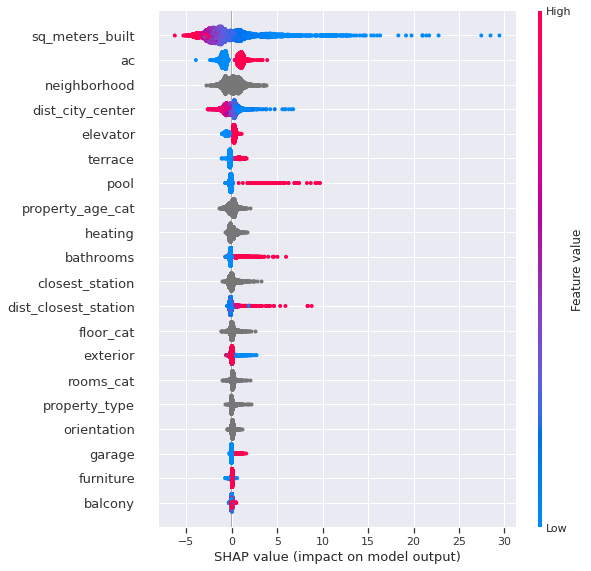

In [53]:
shap.summary_plot(shap_values_cat, X_train)

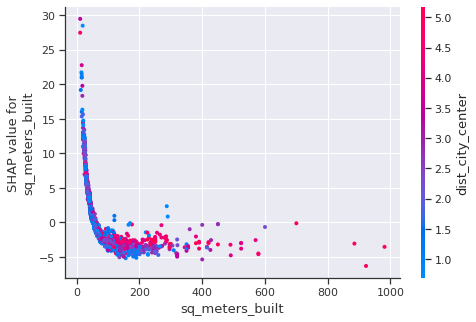

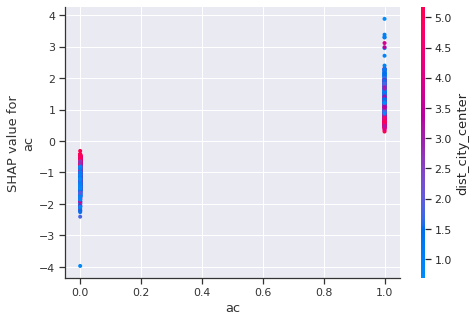

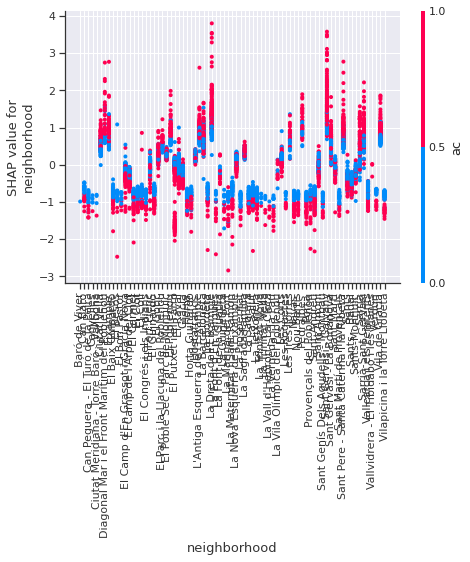

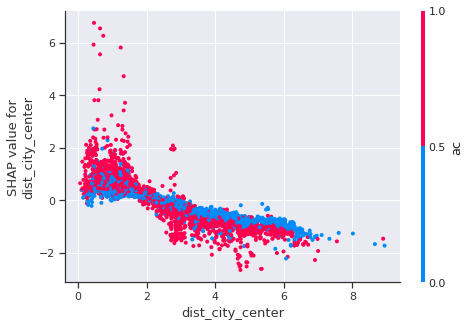

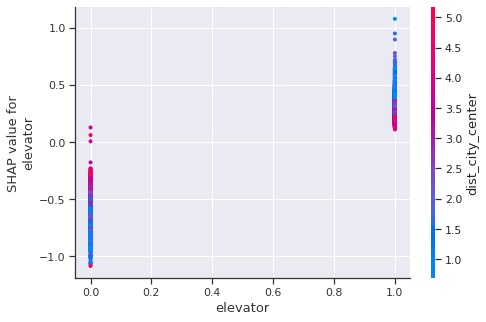

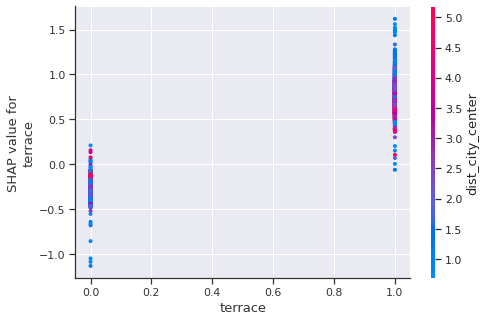

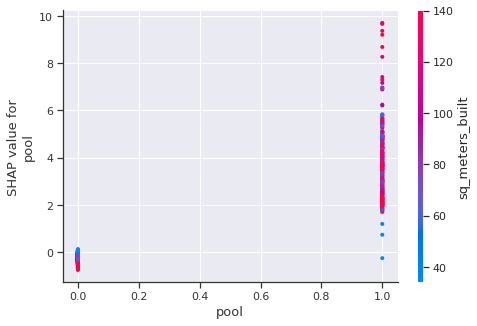

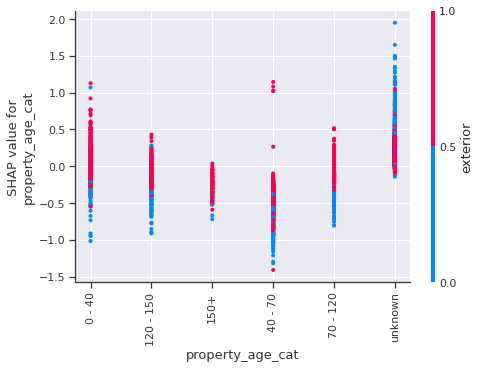

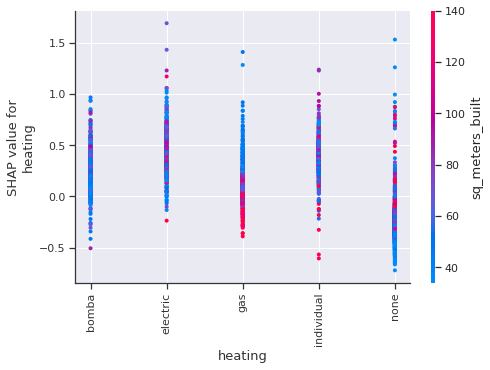

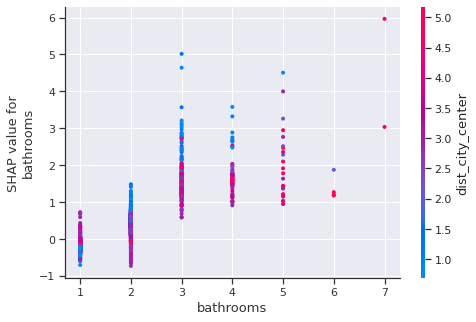

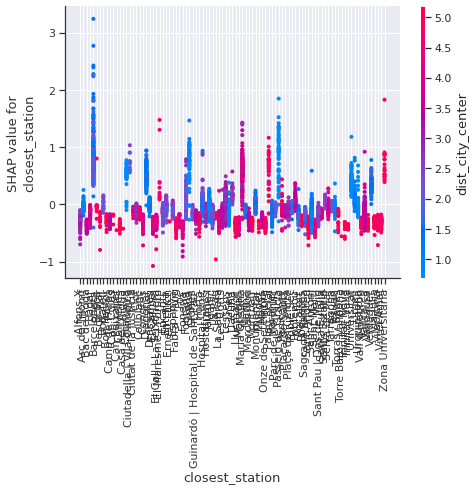

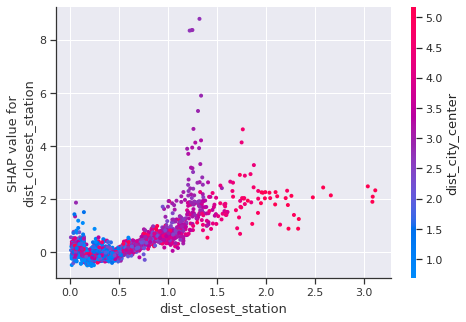

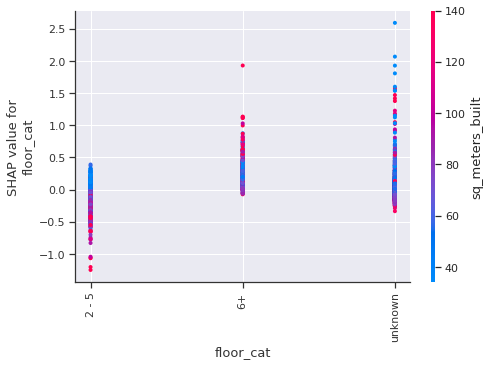

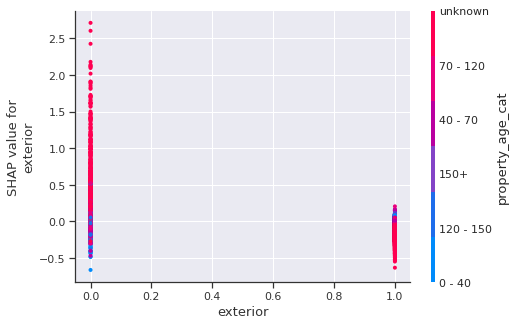

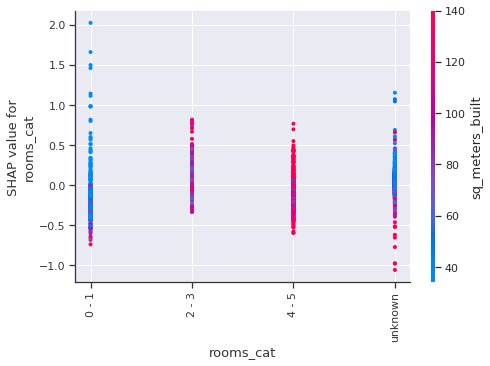

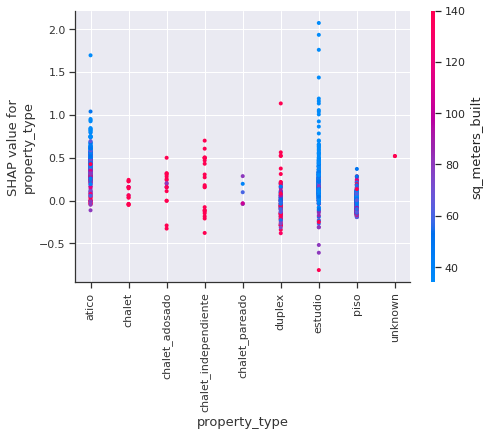

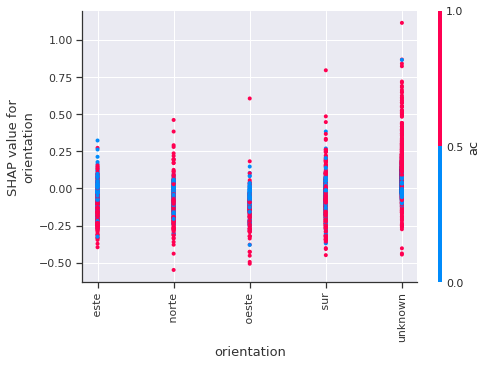

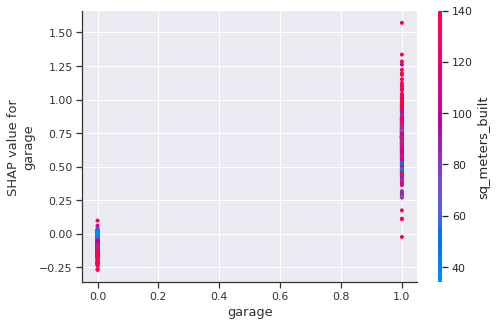

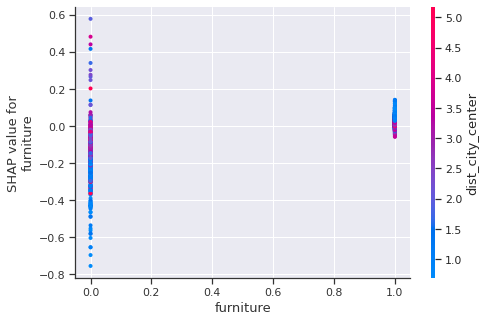

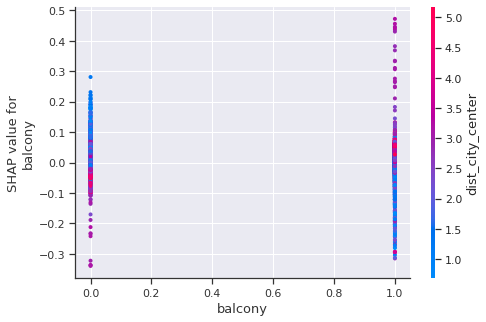

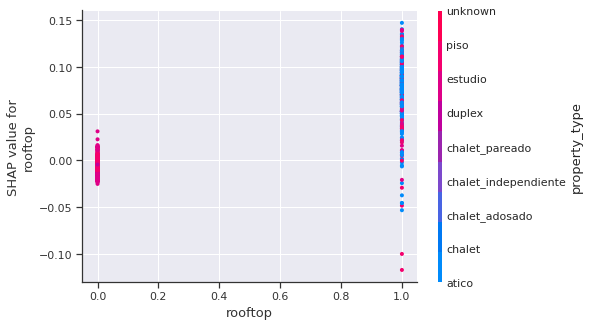

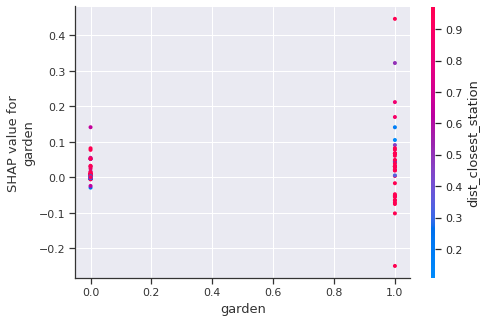

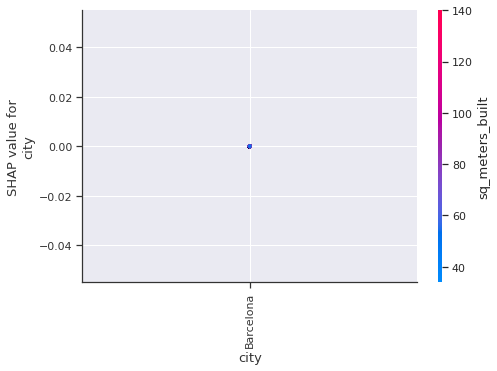

In [54]:
top_inds = np.argsort(-np.sum(np.abs(shap_values_cat), 0))

for i in range(0,len(top_inds)):
    shap.dependence_plot(top_inds[i], shap_values_cat, X_train)

Los SHAP values y sus visualizaciones nos muestran datos muy interesantes. Podemos ver por ejemplo, que las propiedades con menor metraje tendrán siempre un costo por metro cuadrado bastante más alto que el resto, puesto que hay una especie de precio base en las viviendas. 

Por otro lado, también podemos observar que el aire acondicionado, como se vio en el ANOVA y en la matriz de correlación, efectivamente tienen un impacto significativo en el precio, tanto para subirlo cuando existe como para bajarlo cuando no. 

También hay otros patrones observados en el gráfico de forceplot, por ejemplo, en un punto en el que aunque los precios se mantienen por debajo de la media cuando las viviendas tienen más de 50 metros cuadrados, hay un salto hacia arriba, que asumo pueden ser chalets de alto valor como en el caso de Pedrálbes.

---
---
# Generación de predicciones en el dataset de venta y selección de las 20 viviendas más rentables y más baratas para comprar

Finalmente, importamos la data de ventas para poder predecir con nuestro mejor modelo, el CatBoost, los alquileres potenciales para este dataset.

In [55]:
raw_data_ventas = pd.read_csv('Boosting/input/processed_sale_Barcelona.csv', delimiter = ',')
raw_data_ventas.head()

id   price currency   latitude  longitude  sq_meters  \
0    320294  150000        €  41.459649   2.174793       63.0   
1   1786997  150000        €  41.422081   2.155370       48.0   
2   1787143  395000        €  41.402928   2.207851       84.0   
3   1976767  540000        €  41.394692   2.144422        NaN   
4  27972575  650000        €  41.398971   2.120754        NaN   

   sq_meters_built  rooms  bathrooms  balcony  terrace  exterior orientation  \
0               67      3          1      NaN      1.0       1.0        este   
1               52      2          1      NaN      NaN       1.0         NaN   
2               91      2          2      NaN      NaN       1.0         NaN   
3              100      3          1      NaN      NaN       1.0         sur   
4              141      3          2      NaN      NaN       1.0        este   

   floor  rooftop  elevator  doorman  pool   ac     heating  year_built  \
0    5.0      NaN       0.0      NaN   NaN  1.0         NaN         NaN   
1    3.0      NaN       0.0      NaN   NaN  1.0  individual         NaN   
2    NaN      NaN       0.0      NaN   NaN  1.0    electric         NaN   
3    1.0      NaN       1.0      NaN   NaN  1.0         NaN         NaN   
4    1.0      NaN       1.0      NaN   NaN  1.0         NaN         NaN   

   quality       city                              neighborhood  \
0        2  Barcelona  Ciutat Meridiana - Torre Baró - Vallbona   
1        2  Barcelona                                 El Carmel   
2        2  Barcelona                               El Poblenou   
3        2  Barcelona                    Sant Gervasi - Galvany   
4        2  Barcelona                                    Sarrià   

   dist_city_center  furniture  garage property_type  garden  \
0          7.990993        NaN     NaN          piso     NaN   
1          3.991000        NaN     NaN          piso     NaN   
2          3.579261        NaN     NaN        duplex     NaN   
3          2.257852        NaN     1.0          piso     NaN   
4          4.283368        NaN     1.0          piso     NaN   

    closest_station  dist_closest_station       created_at         last_seen  
0  Ciutat Meridiana              0.121438   9/3/2021 10:16  11/12/2021 13:50  
1         El Carmel              0.277336   9/3/2021 10:16  11/12/2021 13:50  
2          Poblenou              0.383878  8/30/2021 12:17   8/30/2021 12:17  
3   Hospital Clínic              0.875652   9/1/2021 14:04    9/2/2021 13:50  
4    Maria Cristina              1.310073  8/29/2021 11:47    9/2/2021 11:01

Se aplican exactamente las mismas transformaciones para que el dataset sea de iguales características al que se le fue alimentado el modelo.

In [58]:
data_trans_ventas = raw_data_ventas.drop(["id", 
                        "doorman", 
                        "latitude", 
                        "longitude",
                        "currency", 
                        "quality", 
                        "sq_meters",
                        "created_at",
                        "last_seen"], axis=1) # inplace=True

for i in range(0,len(data_to_null)):
   data_trans_ventas[data_to_null[i]].fillna(0, inplace = True)
 
data_trans_ventas["orientation"].fillna("unknown", inplace = True)
data_trans_ventas["property_type"].fillna("unknown", inplace = True)

# data_trans_ventas["furniture"].value_counts()
data_trans_ventas["furniture"].fillna(0, inplace = True)
data_trans_ventas["furniture"].replace({3: 1}, inplace=True)

data_trans_ventas["heating"].replace({"na": "none"}, inplace=True)
data_trans_ventas["heating"].replace({0: "none"}, inplace=True)

data_trans_ventas['property_age'] = 2022 - data_trans_ventas['year_built'] # crear year built
data_trans_ventas.drop(["year_built"], axis=1, inplace=True)

func1 = np.vectorize(age_conditions)
data_trans_ventas['property_age_cat'] = func1(data_trans_ventas['property_age'])

func2 = np.vectorize(floor_conditions)
data_trans_ventas['floor_cat'] = func3(data_trans_ventas['floor'])

func3 = np.vectorize(rooms_conditions)
data_trans_ventas['rooms_cat'] = func3(data_trans_ventas['rooms'])

data_trans_ventas.drop(["property_age"], axis=1, inplace=True)
data_trans_ventas.drop(["floor"], axis=1, inplace=True)
data_trans_ventas.drop(["rooms"], axis=1, inplace=True)

data_trans_ventas.head()

price  sq_meters_built  bathrooms  balcony  terrace  exterior orientation  \
0  150000               67          1      0.0      1.0       1.0        este   
1  150000               52          1      0.0      0.0       1.0     unknown   
2  395000               91          2      0.0      0.0       1.0     unknown   
3  540000              100          1      0.0      0.0       1.0         sur   
4  650000              141          2      0.0      0.0       1.0        este   

   rooftop  elevator  pool   ac     heating       city  \
0      0.0       0.0   0.0  1.0        none  Barcelona   
1      0.0       0.0   0.0  1.0  individual  Barcelona   
2      0.0       0.0   0.0  1.0    electric  Barcelona   
3      0.0       1.0   0.0  1.0        none  Barcelona   
4      0.0       1.0   0.0  1.0        none  Barcelona   

                               neighborhood  dist_city_center  furniture  \
0  Ciutat Meridiana - Torre Baró - Vallbona          7.990993        0.0   
1                                 El Carmel          3.991000        0.0   
2                               El Poblenou          3.579261        0.0   
3                    Sant Gervasi - Galvany          2.257852        0.0   
4                                    Sarrià          4.283368        0.0   

   garage property_type  garden   closest_station  dist_closest_station  \
0     0.0          piso     0.0  Ciutat Meridiana              0.121438   
1     0.0          piso     0.0         El Carmel              0.277336   
2     0.0        duplex     0.0          Poblenou              0.383878   
3     1.0          piso     0.0   Hospital Clínic              0.875652   
4     1.0          piso     0.0    Maria Cristina              1.310073   

  property_age_cat floor_cat rooms_cat  
0          unknown     4 - 5     2 - 3  
1          unknown     2 - 3     2 - 3  
2          unknown   unknown     2 - 3  
3          unknown   unknown     2 - 3  
4          unknown   unknown     2 - 3

Corroboramos limpieza de NAs.

In [59]:
data_trans_ventas.isnull().sum() / len(data_trans_ventas) * 100 # Calcula la proporción de null values sobre todas las variables

price                   0.0
sq_meters_built         0.0
bathrooms               0.0
balcony                 0.0
terrace                 0.0
exterior                0.0
orientation             0.0
rooftop                 0.0
elevator                0.0
pool                    0.0
ac                      0.0
heating                 0.0
city                    0.0
neighborhood            0.0
dist_city_center        0.0
furniture               0.0
garage                  0.0
property_type           0.0
garden                  0.0
closest_station         0.0
dist_closest_station    0.0
property_age_cat        0.0
floor_cat               0.0
rooms_cat               0.0
dtype: float64

In [72]:
predictions = model_cat.predict(data_trans_ventas[X_train.columns])
predictions = pd.DataFrame({"pred_precio_m2_mes":predictions})
predictions

pred_precio_m2_mes
0              12.264666
1              14.671995
2              14.762229
3              16.558945
4              15.143352
...                  ...
5842           12.220282
5843           16.547818
5844           25.490258
5845            9.526588
5846            9.427462

[5847 rows x 1 columns]

Y finalmente concatenamos las predicciones de precio por metro cuadrado de alquiler y el precio de alquiler propuesto para cada vivienda, mostrando al final las 20 viviendas más rentables con los precios de compra más baratos, a su vez.

In [73]:
break_even = (data_trans_ventas["price"]/data_trans_ventas["sq_meters_built"])/predictions["pred_precio_m2_mes"]
break_even = pd.DataFrame({"break_even":break_even})
rent_price = data_trans_ventas["sq_meters_built"]*predictions["pred_precio_m2_mes"]
rent_price = pd.DataFrame({"precio_alquiler":rent_price})

In [74]:
with_pred = pd.concat([break_even, predictions, rent_price, data_trans_ventas],axis=1)
with_pred.sort_values(["break_even","price"]).head(20)

break_even  pred_precio_m2_mes  precio_alquiler  price  sq_meters_built  \
410    29.317940           12.364443       989.155455  29000               80   
3408   40.385716           16.666213       866.643057  35000               52   
1800   42.162252           11.529534       830.126443  35000               72   
5697   42.671479           15.773461       820.219981  35000               52   
2896   43.823706           13.889644       638.923601  28000               46   
1218   46.393026           11.873497      1401.072641  65000              118   
2829   56.561661           15.373757       707.192813  40000               46   
5546   58.897520           26.486684       662.167097  39000               25   
2347   62.719718           14.863004       876.917211  55000               59   
123    63.304631           10.011950       710.848464  45000               71   
5117   66.056581           18.166244       726.649778  48000               40   
4688   67.625049           17.744904       709.796163  48000               40   
3105   71.262045            9.911997      1248.911679  89000              126   
72     72.396047           39.597006       593.955083  43000               15   
5073   73.452197           15.170216      1061.915135  78000               70   
2332   74.187361           21.297428       532.435707  39500               25   
5618   76.554625           12.191730       731.503807  56000               60   
2215   80.302997           16.437743      1232.830705  99000               75   
5254   80.350252           12.656453       746.730699  60000               59   
5543   81.993618           13.903521       695.176055  57000               50   

      bathrooms  balcony  terrace  exterior orientation  rooftop  elevator  \
410           2      1.0      0.0       0.0     unknown      0.0       1.0   
3408          1      1.0      0.0       1.0         sur      0.0       1.0   
1800          1      0.0      0.0       0.0     unknown      0.0       1.0   
5697          1      1.0      0.0       1.0         sur      0.0       1.0   
2896          1      0.0      0.0       0.0     unknown      0.0       0.0   
1218          2      1.0      0.0       0.0     unknown      0.0       1.0   
2829          1      0.0      0.0       1.0         sur      0.0       0.0   
5546          1      0.0      0.0       0.0     unknown      0.0       1.0   
2347          1      0.0      0.0       0.0     unknown      0.0       1.0   
123           1      0.0      0.0       0.0     unknown      0.0       0.0   
5117          2      0.0      0.0       0.0        este      0.0       1.0   
4688          1      0.0      0.0       0.0     unknown      0.0       1.0   
3105          2      0.0      1.0       0.0         sur      0.0       0.0   
72            1      0.0      0.0       1.0     unknown      0.0       0.0   
5073          3      0.0      0.0       1.0     unknown      0.0       0.0   
2332          1      0.0      0.0       1.0     unknown      0.0       0.0   
5618          1      0.0      1.0       1.0         sur      0.0       0.0   
2215          1      1.0      0.0       1.0     unknown      0.0       1.0   
5254          1      0.0      0.0       1.0     unknown      0.0       0.0   
5543          1      0.0      0.0       0.0     unknown      0.0       0.0   

      pool   ac     heating       city  \
410    0.0  0.0  individual  Barcelona   
3408   0.0  0.0    electric  Barcelona   
1800   0.0  0.0  individual  Barcelona   
5697   0.0  0.0        none  Barcelona   
2896   0.0  0.0        none  Barcelona   
1218   0.0  1.0  individual  Barcelona   
2829   0.0  0.0        none  Barcelona   
5546   0.0  0.0        none  Barcelona   
2347   0.0  0.0        none  Barcelona   
123    0.0  0.0        none  Barcelona   
5117   0.0  0.0        none  Barcelona   
4688   0.0  0.0        none  Barcelona   
3105   0.0  0.0        none  Barcelona   
72     0.0  0.0        none  Barcelona   
5073   0.0  1.0         gas  Barcel

Si hay algo que puede ser rescatado del ejercicio, adicionalmente al hecho de que el modelo de CatBoost efectivamente puede lograr mejores resutlados y un análsis más rico gracias a los SHAP values, de todas maneras el pre-procesamiento de los datos son clave para la mejor performance de los modelos. 

Existen múltiples distinas formas en las que se podría haber tratado la data, como por ejemplo realizar pruebas eliminando registros que tengan NAs en variables clave interesantes como heating, o también realizar pruebas eliminando más de las variables con altos NAs que en este caso fueron transformadas a 0.
Otro ejemplo podría ser el uso de clustering para realizar las agrupaciones de variables como las que se plantearon arbitrariamente en este ejercicio (floor, rooms, price) para que el agrupamiento sea más fino y con un mayor sentido a la simple intuición.

El bagging y boosting son herramientas altamente útiles en la predicción de datos para datasets medianamente complejos con cantidades de datos considerables pero no demasiado abuntantes. Logrando una R2 superando el 0.85, podemos lograr estimaciones de alto valor para la toma de decisiones.